In [24]:
%matplotlib inline

from pathlib import Path
from random import sample

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm_notebook as tqdm

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [2]:
# Data from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#mnist

def load_xy(folder, pbar=True):
    with (folder / 'data').open('r') as f:
        data = f.readlines()
    if pbar:
        data = tqdm(data)
    
    xs = np.zeros((len(data), 784), dtype=np.float32)
    ys = np.zeros(len(data), dtype=np.int32)
    for i, line in enumerate(data):
        ts = line.split()
        ys[i] = int(ts[0])
        for t in ts[1:]:
            idx = t.find(':')
            xs[i][int(t[:idx]) - 1] = int(t[idx + 1:]) / 255
    
    return xs, ys

data = Path('../data/')
x_train, y_train = load_xy(data / 'mnist', pbar=False)
x_valid, y_valid = load_xy(data / 'mnist.t', pbar=False)

In [70]:
class Visualizer(object):
    def __init__(self, cmap=plt.cm.tab10_r, method=None, n_classes=10):
        self.cmap = cmap
        self.method = method or PCA(n_components=2)
        self.n_classes = n_classes
    
    def fit(self, xs):
        self.method.fit(xs)
        
    def plot(self, xs, ys, ax=None, title=''):
        xs, ys = xs[:5000], ys[:5000]
        xs = self.method.transform(xs)
        ax = ax if ax else plt.subplot()
        for y in range(self.n_classes):
            data = xs[ys == y, :]
            ax.scatter(data[:, 0], data[:, 1], 
                       c=self.cmap(y / self.n_classes), label=y, edgecolors='k')
        ax.legend(loc='lower right', frameon=True)
        ax.set_title(title)
        return ax
    
vis = Visualizer()
vis.fit(x_train)

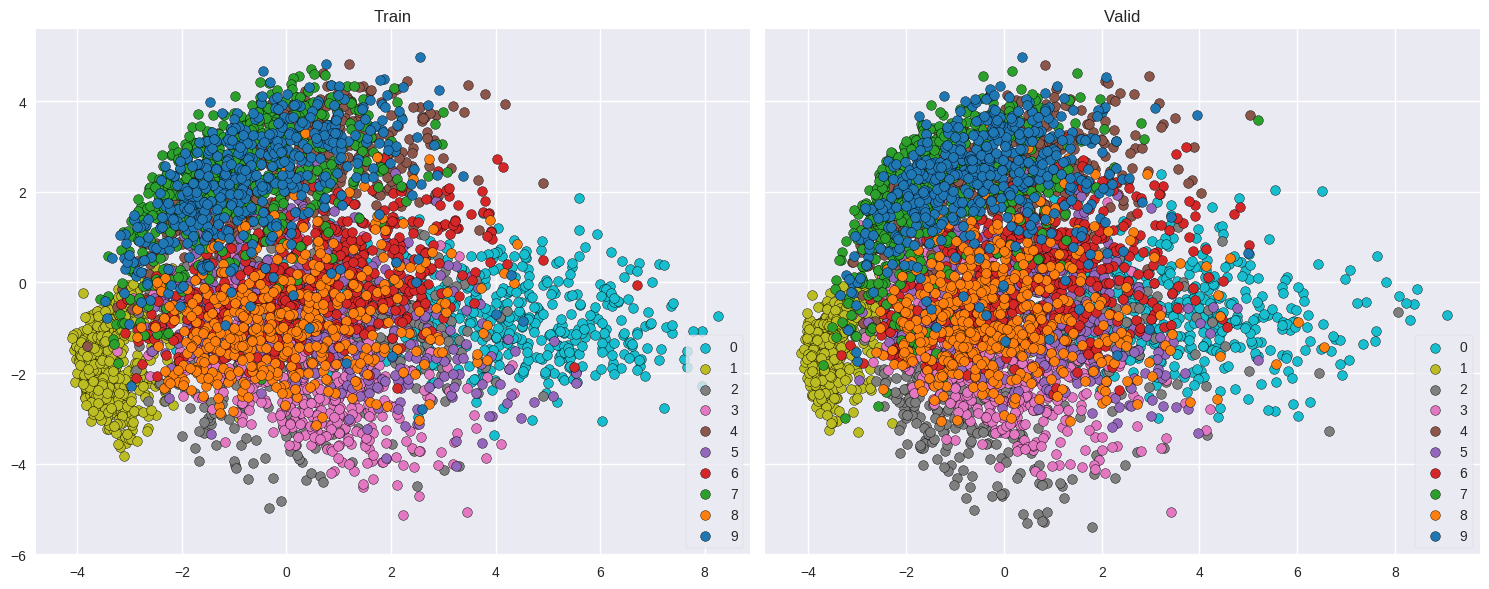

In [50]:
fig, ax = plt.subplots(1, 2, sharey=True, dpi=100, figsize=(15, 6))
vis.plot(x_train, y_train, ax=ax[0], title='Train')
vis.plot(x_valid, y_valid, ax=ax[1], title='Valid')
fig.tight_layout()
plt.show()

In [93]:
%%time

pca = PCA(n_components=20)
pca.fit(x_train)
xt, yt = pca.transform(x_train), y_train
xv, yv = pca.transform(x_valid), y_valid
print(pca.explained_variance_ratio_.cumsum())

[ 0.09704707  0.16800669  0.22969797  0.28359246  0.3322807   0.3754032
  0.40812269  0.4369618   0.4645822   0.48815233  0.50924432  0.52947432
  0.54663259  0.56355375  0.57934022  0.59416974  0.60741514  0.62018365
  0.63205522  0.64358187]
CPU times: user 7.66 s, sys: 9.86 s, total: 17.5 s
Wall time: 6.37 s


In [94]:
%%time

svc = SVC(C=1.0, kernel='poly', verbose=True)
svc.fit(xt, yt)
print(svc.score(xv, yv))

[LibSVM]0.9756
CPU times: user 26.7 s, sys: 9.02 ms, total: 26.7 s
Wall time: 26.9 s


In [16]:
%%time

rf = RandomForestClassifier(n_estimators=20)
rf.fit(x_train, y_train)
print(rf.score(x_valid, y_valid))

0.9594
CPU times: user 10.3 s, sys: 18.3 ms, total: 10.3 s
Wall time: 10.7 s


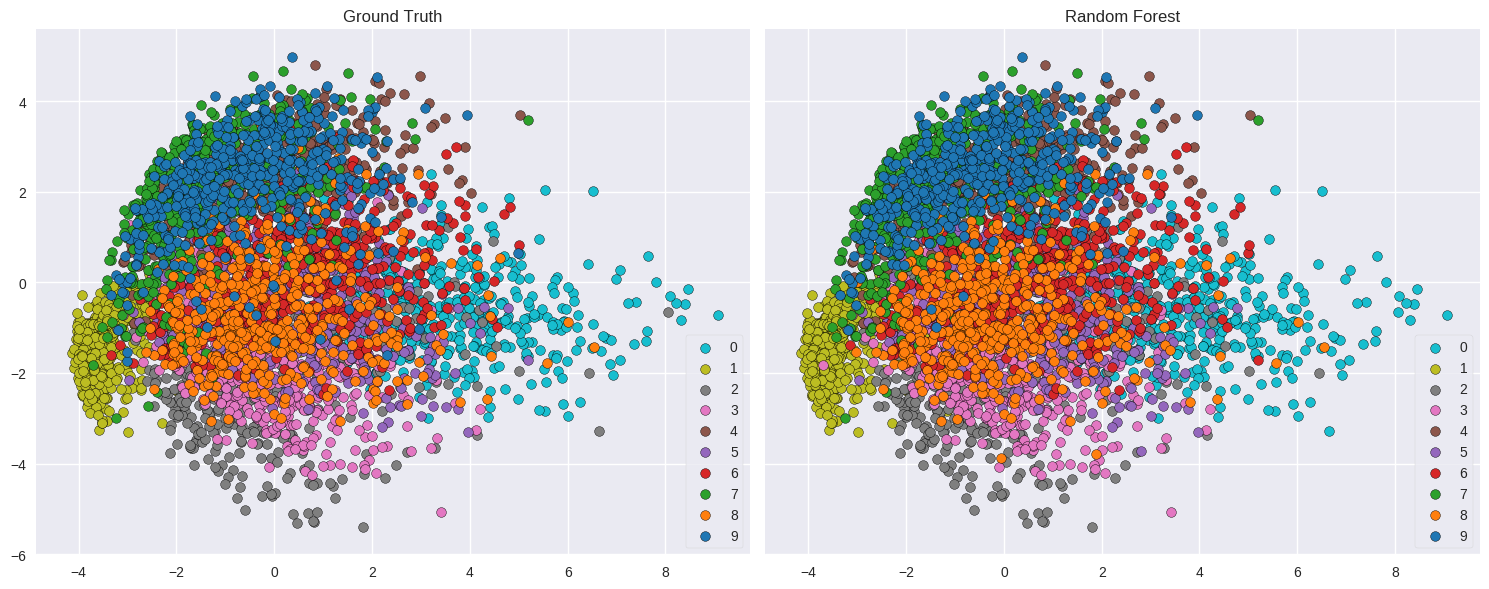

In [67]:
y_true = y_valid
y_pred = rf.predict(x_valid)

fig, ax = plt.subplots(1, 2, sharey=True, dpi=100, figsize=(15, 6))
vis.plot(x_valid, y_true, ax=ax[0], title='Ground Truth')
vis.plot(x_valid, y_pred, ax=ax[1], title='Random Forest')
fig.tight_layout()
plt.show()